## Assignment 2: Network Safety


#### CSC 180  Intelligent Systems (Spring 2020)

#### Ace English

# Helpful Functions for Tensorflow

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [12]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)
    

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)
    

# Metrics: 

For any type of classification neural network:

* **Accuracy** 
* **Precision** 
* **Recall** 
* **F1 Score** 
* **Log Loss**
* **Confusion Matrix** 
* **ROC Curve** 

The code used to produce Confusion matrix and ROC curve is shown here:

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Visualizing binary classification models


Binary classification is used to create a model that classifies between only two classes.  These two classes are often called "positive" and "negative". 


In [14]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Set the desired TensorFlow output level for this example
# tf.logging.set_verbosity(tf.logging.ERROR)


df = pd.read_csv("network_intrusion_data.csv")
df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]

df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


## Data Examination
Now we clean the data. Part of this process is checking for redundant records and records with missing values. Like normal, we will encode categorical data and normalizing numerical data.

Data types of each row:

In [31]:
datatype={}

datatype["duration"] = "continuous"
datatype["protocol_type"] = "symbolic"
datatype["service"] = "symbolic"
datatype["flag"] = "symbolic"
datatype["src_bytes"] = "continuous"
datatype["dst_bytes"] = "continuous"
datatype["land"] = "symbolic"
datatype["wrong_fragment"] = "continuous"
datatype["urgent"] = "continuous"
datatype["hot"] = "continuous"
datatype["num_failed_logins"] = "continuous"
datatype["logged_in"] = "symbolic"
datatype["num_compromised"] = "continuous"
datatype["root_shell"] = "continuous"
datatype["su_attempted"] = "continuous"
datatype["num_root"] = "continuous"
datatype["num_file_creations"] = "continuous"
datatype["num_shells"] = "continuous"
datatype["num_access_files"] = "continuous"
datatype["num_outbound_cmds"] = "continuous"
datatype["is_host_login"] = "symbolic"
datatype["is_guest_login"] = "symbolic"
datatype["count"] = "continuous"
datatype["srv_count"] = "continuous"
datatype["serror_rate"] = "continuous"
datatype["srv_serror_rate"] = "continuous"
datatype["rerror_rate"] = "continuous"
datatype["srv_rerror_rate"] = "continuous"
datatype["same_srv_rate"] = "continuous"
datatype["diff_srv_rate"] = "continuous"
datatype["srv_diff_host_rate"] = "continuous"
datatype["dst_host_count"] = "continuous"
datatype["dst_host_srv_count"] = "continuous"
datatype["dst_host_same_srv_rate"] = "continuous"
datatype["dst_host_diff_srv_rate"] = "continuous"
datatype["dst_host_same_src_port_rate"] = "continuous"
datatype["dst_host_srv_diff_host_rate"] = "continuous"
datatype["dst_host_serror_rate"] = "continuous"
datatype["dst_host_srv_serror_rate"] = "continuous"
datatype["dst_host_rerror_rate"] = "continuous"
datatype["dst_host_srv_rerror_rate"] = "continuous"
datatype["outcome"] = "symbolic"

# Search for duplicates and remove

In [16]:
df_dupes=df[df.duplicated()]
print ("Removing ",df_dupes.shape[0]," duplicate entries...")
df_unique=df.drop_duplicates()
print(df_unique)

Removing  348435  duplicate entries...
        duration protocol_type service flag  src_bytes  dst_bytes  land  \
0              0           tcp    http   SF        239        486     0   
1              0           tcp    http   SF        235       1337     0   
2              0           tcp    http   SF        219       1337     0   
3              0           tcp    http   SF        217       2032     0   
4              0           tcp    http   SF        217       2032     0   
...          ...           ...     ...  ...        ...        ...   ...   
494015         0           tcp    http   SF        310       1881     0   
494016         0           tcp    http   SF        282       2286     0   
494017         0           tcp    http   SF        203       1200     0   
494018         0           tcp    http   SF        291       1200     0   
494019         0           tcp    http   SF        219       1234     0   

        wrong_fragment  urgent  hot  ...  dst_host_srv_count

Next I want to check all columns to see what the expected outputs are and if any of them are invalid.

In [17]:
for (colName, colData) in df_unique.iteritems():
    valueCount=colData.drop_duplicates()
    print(colName, "-",valueCount.size, valueCount.values)

duration - 2495 [   0    1   79 ... 2695 2751  120]
protocol_type - 3 ['tcp' 'udp' 'icmp']
service - 66 ['http' 'smtp' 'finger' 'domain_u' 'auth' 'telnet' 'ftp' 'eco_i' 'ntp_u'
 'ecr_i' 'other' 'private' 'pop_3' 'ftp_data' 'rje' 'time' 'mtp' 'link'
 'remote_job' 'gopher' 'ssh' 'name' 'whois' 'domain' 'login' 'imap4'
 'daytime' 'ctf' 'nntp' 'shell' 'IRC' 'nnsp' 'http_443' 'exec' 'printer'
 'efs' 'courier' 'uucp' 'klogin' 'kshell' 'echo' 'discard' 'systat'
 'supdup' 'iso_tsap' 'hostnames' 'csnet_ns' 'pop_2' 'sunrpc' 'uucp_path'
 'netbios_ns' 'netbios_ssn' 'netbios_dgm' 'sql_net' 'vmnet' 'bgp' 'Z39_50'
 'ldap' 'netstat' 'urh_i' 'X11' 'urp_i' 'pm_dump' 'tftp_u' 'tim_i' 'red_i']
flag - 11 ['SF' 'S1' 'REJ' 'S2' 'S0' 'S3' 'RSTO' 'RSTR' 'RSTOS0' 'OTH' 'SH']
src_bytes - 3300 [239 235 219 ... 500 484 475]
dst_bytes - 10725 [  486  1337  2032 ... 34557 10592 13828]
land - 2 [0 1]
wrong_fragment - 3 [0 1 3]
urgent - 4 [0 2 1 3]
hot - 22 [ 0  1  3 19  6  4 30 24 14 18  2  5 17 22  7 16 12 20 10 28 

dst_host_diff_srv_rate - 101 [0.   0.25 0.17 0.14 0.11 0.1  0.09 0.07 0.06 0.05 0.04 0.4  0.2  0.16
 0.08 0.02 0.15 0.13 0.12 0.67 0.03 0.75 0.21 0.3  0.22 0.33 1.   0.29
 0.19 0.5  0.36 0.27 0.18 0.01 0.44 0.6  0.38 0.43 0.24 0.23 0.26 0.28
 0.31 0.34 0.9  0.8  0.72 0.65 0.55 0.51 0.48 0.45 0.42 0.93 0.83 0.74
 0.61 0.56 0.52 0.49 0.46 0.91 0.81 0.66 0.94 0.62 0.57 0.53 0.99 0.87
 0.77 0.7  0.63 0.58 0.54 0.47 0.41 0.39 0.37 0.35 0.88 0.78 0.64 0.59
 0.97 0.86 0.76 0.69 0.89 0.79 0.71 0.32 0.96 0.85 0.68 0.92 0.82 0.73
 0.84 0.95 0.98]
dst_host_same_src_port_rate - 101 [0.05 0.03 0.02 1.   0.09 0.12 0.06 0.04 0.25 0.07 0.01 0.33 0.08 0.2
 0.5  0.1  0.   0.17 0.14 0.18 0.27 0.22 0.11 0.99 0.79 0.72 0.57 0.64
 0.7  0.73 0.75 0.23 0.15 0.21 0.24 0.98 0.43 0.19 0.3  0.13 0.55 0.37
 0.62 0.28 0.71 0.32 0.6  0.36 0.39 0.42 0.44 0.48 0.52 0.56 0.68 0.76
 0.8  0.84 0.87 0.91 0.95 0.16 0.31 0.41 0.38 0.4  0.45 0.26 0.35 0.82
 0.9  0.94 0.96 0.97 0.29 0.34 0.46 0.47 0.49 0.51 0.53 0.54 0.58 0.8

All this data looks valid.

`num_outbound_cmds` and `is_host_login` both have only 1 entry type, so they can be dropped.
Next I want to see what kind of sample sizes we can work with which each of these, so instead of just returning each list I want to produce a count.

In [63]:
#drop worthless data
df_unique=df_unique.drop(['is_host_login','num_outbound_cmds'], axis=1)

#check values count
i=0
for (colName, colData) in df_unique.iteritems():
    value_counts=colData.value_counts();
    print("Name: ",colName," Type: ",list(datatype)[i], "Size:", value_counts.size)
    print(value_counts.sort_values(ascending=False))
    print()
    i=i+1

Name:  duration  Type:  duration Size: 2495
0        134974
1          2441
2           853
3           604
5           407
          ...  
3171          1
5344          1
3299          1
17770         1
6543          1
Name: duration, Length: 2495, dtype: int64

Name:  protocol_type  Type:  protocol_type Size: 3
tcp     130912
udp      12267
icmp      2406
Name: protocol_type, dtype: int64

Name:  service  Type:  service Size: 66
http        62053
private     49057
smtp         9721
domain_u     5425
other        4769
            ...  
X11            11
tim_i           5
pm_dump         1
tftp_u          1
red_i           1
Name: service, Length: 66, dtype: int64

Name:  flag  Type:  flag Size: 11
SF        87458
S0        42278
REJ       14712
RSTO        569
RSTR        425
S1           57
SH           34
S2           24
RSTOS0       11
S3           10
OTH           7
Name: flag, dtype: int64

Name:  src_bytes  Type:  src_bytes Size: 3300
0        57872
147       1962
105       1467

Name:  dst_host_same_src_port_rate  Type:  dst_host_same_srv_rate Size: 101
0.00    80614
0.01    20205
0.02     7178
1.00     5496
0.03     4398
        ...  
0.76       34
0.70       32
0.72       28
0.68       27
0.66       26
Name: dst_host_same_src_port_rate, Length: 101, dtype: int64

Name:  dst_host_srv_diff_host_rate  Type:  dst_host_diff_srv_rate Size: 65
0.00    94794
0.02    11736
0.01    10529
0.04     6670
0.03     6624
        ...  
0.45        1
0.75        1
0.58        1
0.62        1
0.70        1
Name: dst_host_srv_diff_host_rate, Length: 65, dtype: int64

Name:  dst_host_serror_rate  Type:  dst_host_same_src_port_rate Size: 100
0.00    97044
1.00    41965
0.01     3385
0.02      955
0.03      398
        ...  
0.66        1
0.71        1
0.78        1
0.86        1
0.83        1
Name: dst_host_serror_rate, Length: 100, dtype: int64

Name:  dst_host_srv_serror_rate  Type:  dst_host_srv_diff_host_rate Size: 72
0.00    97588
1.00    42196
0.01     4592
0.02      675
0.

Here we see that several of the fields have a huge disparity in volume. `urgent` is almost entirely 0. Several other fields have a huge majority of one field with other fields being rare. However, several of these may be crucial for finding attacks.


`wrong_fragment`, `num_failed_logins`, `num_compromised`, `hot`, `root_shell`, `su_attempted`, `num_root`, `num_file_creations`, `num_shells`, `is_guest_login`, `num_access_files`
## Separating attacks from normal

In [64]:
outliers=['outcome','land','wrong_fragment', 'num_failed_logins', 'num_compromised', 'hot', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'is_guest_login', 'num_access_files']
df_normals=df_unique[df_unique['outcome']=='normal.']
df_attacks=df_unique.drop(df_normals.index)

i=0
for (colName, colData) in df_attacks.iteritems():
    if(colName in outliers):
        value_counts=colData.value_counts();
        print("Name: ",colName," Type: ",list(datatype)[i], "Size:", value_counts.size)
        print(value_counts.sort_values(ascending=False))
        print()
    i=i+1

Name:  land  Type:  land Size: 2
0    57735
1       19
Name: land, dtype: int64

Name:  wrong_fragment  Type:  wrong_fragment Size: 3
0    56633
3      910
1      211
Name: wrong_fragment, dtype: int64

Name:  hot  Type:  hot Size: 14
0     56339
2       917
28      274
1       133
3        34
5        16
4        15
20        9
6         8
19        5
7         1
10        1
15        1
18        1
Name: hot, dtype: int64

Name:  num_failed_logins  Type:  num_failed_logins Size: 3
0    57701
1       52
5        1
Name: num_failed_logins, dtype: int64

Name:  num_compromised  Type:  num_compromised Size: 10
0     56832
1       901
2         8
4         7
3         1
5         1
6         1
38        1
16        1
22        1
Name: num_compromised, dtype: int64

Name:  root_shell  Type:  root_shell Size: 2
0    57722
1       32
Name: root_shell, dtype: int64

Name:  su_attempted  Type:  su_attempted Size: 2
0    57753
1        1
Name: su_attempted, dtype: int64

Name:  num_root  Type:  

Surprisingly a lot of these values are still disproportionate even among errors only. Many of them will get dropped later.

`num_failed_logins`,`root_shell`,`su_attempted`,`num_root`, `num_file_creations`,`num_shells`, `num_access_files` seem irrelevent and have very little data to go off of.

In [65]:
drop_columns=['urgent','land','num_failed_logins', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files']
#Model using fewer of the good samples - same number as most common error
df_downsampled=df_normals.sample(51820).append(df_attacks)
#model dropping rows that might be irrelevent
df_slim=df_unique.drop(drop_columns,axis=1)
#model dropping irrelevent rows AND using downsampling
df_slim_downsampled=df_downsampled.drop(drop_columns,axis=1)

print(df_unique.shape)
print(df_downsampled.shape)
print(df_slim.shape)
print(df_slim_downsampled.shape)


(145585, 40)
(109574, 40)
(145585, 31)
(109574, 31)


## Normalization and one-hot encoding

For `outcome` we don't care what the error code is (just that it is not normal)

In [66]:
#get arrays for training
y=df_slim_downsampled["outcome"].values
df_data=df_slim_downsampled.drop(["outcome"], axis=1)

#prep for model
for (name,column) in df_data.iteritems():
    #
    if(datatype[name]=='continuous'):
        encode_numeric_zscore(df_data, name)
    else:
        encode_text_dummy(df_data,name)

df_data

,duration,src_bytes,dst_bytes,wrong_fragment,hot,num_compromised,count,srv_count,serror_rate,srv_serror_rate,...,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH,logged_in-0,logged_in-1,is_guest_login-0,is_guest_login-1
41632,-0.096151,-0.004753,-0.039284,-0.097392,-0.074437,-0.007774,-0.879640,-0.313738,-0.796225,-0.795152,...,0,0,0,0,1,0,0,1,1,0
85260,-0.096151,-0.004760,0.094378,-0.097392,-0.074437,-0.007774,-0.889009,-0.374454,-0.796225,-0.795152,...,0,0,0,0,1,0,0,1,1,0
32743,-0.096151,-0.004717,-0.032799,-0.097392,-0.074437,-0.007774,-0.879640,0.263070,-0.796225,-0.795152,...,0,0,0,0,1,0,0,1,1,0
79716,-0.096151,-0.004744,-0.025014,-0.097392,-0.074437,-0.007774,-0.814061,-0.040513,-0.796225,-0.795152,...,0,0,0,0,1,0,0,1,1,0
2621,-0.096151,-0.004740,-0.034756,-0.097392,-0.074437,-0.007774,-0.823429,-0.010154,-0.796225,-0.795152,...,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490959,-0.096151,-0.004831,-0.039284,10.788337,-0.074437,-0.007774,-0.626691,0.475579,-0.796225,-0.795152,...,0,0,0,0,1,0,1,0,1,0
490960,-0.096151,-0.004831,-0.039284,10.788337,-0.074437,-0.007774,-0.617323,0.505937,-0.796225,-0.795152,...,0,0,0,0,1,0,1,0,1,0
490961,-0.096151,-0.004831,-0.039284,10.788337,-0.074437,-0.007774,-0.607954,0.536295,-0.796225,-0.795152,...,0,0,0,0,1,0,1,0,1,0
490962,-0.096151,-0.004831,-0.039284,10.788337,-0.074437,-0.007774,-0.598586,0.566654,-0.796225,-0.795152,...,0,0,0,0,1,0,1,0,1,0


In [72]:
#show me again dammit
i=0
for (colName, colData) in df_data.iteritems():
    value_counts=colData.value_counts();
    print("Name: ",colName," Type: ",list(datatype)[i], "Size:", value_counts.size)
    print(value_counts.sort_values(ascending=False))
    print()
    i=i+1

Name:  duration  Type:  duration Size: 1763
-0.096151     102988
-0.095324       1492
-0.094497        539
-0.093670        357
-0.092844        260
               ...  
 7.502199          1
 25.136322         1
 6.654722          1
 1.071300          1
 5.056506          1
Name: duration, Length: 1763, dtype: int64

Name:  src_bytes  Type:  protocol_type Size: 2786
-0.004844    55886
-0.004774     1184
-0.004831      922
 0.021150      908
-0.004794      877
             ...  
-0.004618        1
-0.003238        1
 0.000871        1
-0.004808        1
-0.003688        1
Name: src_bytes, Length: 2786, dtype: int64

Name:  dst_bytes  Type:  service Size: 8529
-0.039284    63017
-0.037715     1916
 0.084949      899
-0.034353      487
-0.034368      486
             ...  
 0.058456        1
 0.136950        1
 0.089163        1
 1.452535        1
 0.088207        1
Name: dst_bytes, Length: 8529, dtype: int64

Name:  wrong_fragment  Type:  flag Size: 3
-0.097392     108453
 10.788337     

Name:  protocol_type-icmp  Type:  srv_serror_rate Size: 2
0    107534
1      2040
Name: protocol_type-icmp, dtype: int64

Name:  protocol_type-tcp  Type:  rerror_rate Size: 2
1    99798
0     9776
Name: protocol_type-tcp, dtype: int64

Name:  protocol_type-udp  Type:  srv_rerror_rate Size: 2
0    101838
1      7736
Name: protocol_type-udp, dtype: int64

Name:  service-IRC  Type:  same_srv_rate Size: 2
0    109548
1        26
Name: service-IRC, dtype: int64

Name:  service-X11  Type:  diff_srv_rate Size: 2
0    109568
1         6
Name: service-X11, dtype: int64

Name:  service-Z39_50  Type:  srv_diff_host_rate Size: 2
0    109483
1        91
Name: service-Z39_50, dtype: int64

Name:  service-auth  Type:  dst_host_count Size: 2
0    109344
1       230
Name: service-auth, dtype: int64

Name:  service-bgp  Type:  dst_host_srv_count Size: 2
0    109470
1       104
Name: service-bgp, dtype: int64

Name:  service-courier  Type:  dst_host_same_srv_rate Size: 2
0    109466
1       108
Name: ser

IndexError: list index out of range

In [73]:
  
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(df_data, y, test_size=0.25, random_state=42) 

[[0 'tcp' 'http' ... 0.0 0.0 0.0]
 [0 'tcp' 'http' ... 0.0 0.0 0.0]
 [0 'tcp' 'http' ... 0.0 0.0 0.0]
 ...
 [0 'udp' 'private' ... 0.0 0.0 0.0]
 [0 'udp' 'private' ... 0.0 0.0 0.0]
 [0 'udp' 'private' ... 0.0 0.0 0.0]]


# Model Training
## KNN

In [74]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(df_data,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

## Testing

In [77]:
pred = knn.predict(x_test)
pred

array(['neptune.', 'neptune.', 'neptune.', ..., 'normal.', 'warezclient.',
       'neptune.'], dtype=object)

# Visualization

[[  252     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]
 [    0     4     0     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     1     0]
 [    0     0     2     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     1     0]
 [    0     0     0    14     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     3     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0   135     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     7     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0    

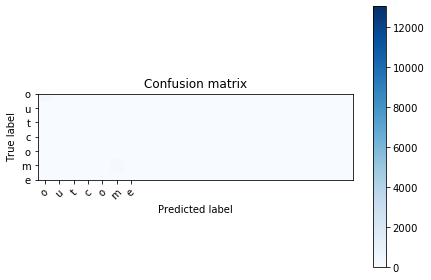

D:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  precision    recall  f1-score   support

           back.       1.00      1.00      1.00       252
buffer_overflow.       0.67      0.67      0.67         6
      ftp_write.       0.67      0.67      0.67         3
   guess_passwd.       0.93      1.00      0.97        14
           imap.       1.00      0.75      0.86         4
        ipsweep.       0.97      1.00      0.99       135
           land.       1.00      1.00      1.00         7
     loadmodule.       1.00      0.50      0.67         2
       multihop.       0.33      1.00      0.50         1
        neptune.       1.00      1.00      1.00     12908
           nmap.       1.00      0.93      0.96        42
         normal.       1.00      1.00      1.00     13033
           perl.       0.00      0.00      0.00         1
            phf.       0.50      1.00      0.67         1
            pod.       1.00      1.00      1.00        53
      portsweep.       0.99      1.00      0.99        99
        rootk

In [80]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, 'outcome')
plt.show()

print(classification_report(y_test, pred))

### Jump out of local optimum by using a loop!!

In [60]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)


print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

0


IndexError: tuple index out of range

### Confusion Matrix

The confusion matrix is a common visualization for both binary and multi-class classification problems.  The following code generates a confusion matrix:

In [ ]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, diagnosis)
plt.show()

print(classification_report(y_true, pred))

### ROC Curves

**An ROC curve measures how good a model is regardless of the cutoff.** 

The following code shows an ROC chart for the breast cancer neural network.  The area under the curve (AUC) is also an important measure.  The larger the AUC, the better.

In [ ]:
pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)

# Visualizing multi-class classification models

We've already seen multi-class classification, with the iris dataset.  Confusion matrixes work just fine with 3 classes.  The following code generates a confusion matrix for iris.

In [ ]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

path = "./data/"
    
filename = os.path.join(path,"iris.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

species = encode_text_index(df,"species")
x,y = to_xy(df,"species")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
model.add(Dense(10))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('dnn/best_weights.hdf5') # load weights from best model

In [ ]:
import numpy as np

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, species)
plt.show()


print(classification_report(y_true, pred))

# Visualizing regression models

We've already seen regression with the MPG dataset.  Regression uses its own set of visualizations, one of the most common is the lift chart.  The following code generates a lift chart.

In [ ]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


path = "./data/"
preprocess = False

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
encode_text_dummy(df, 'origin')
df.drop('name',1,inplace=True)
if preprocess:
    encode_numeric_zscore(df, 'horsepower')
    encode_numeric_zscore(df, 'weight')
    encode_numeric_zscore(df, 'cylinders')
    encode_numeric_zscore(df, 'displacement')
    encode_numeric_zscore(df, 'acceleration')
    encode_numeric_zscore(df, 'year')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

model = Sequential()
model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)

model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test, sort=True)

The lift chart as shown above was achieved by performing the following actions:

* Sort the data by expected output.  Plot the blue line above.  Blue line is always increasing. 
* For every point on the x-axis plot the predicted value for that same data point.  This is the orange line above.
* The x-axis is the index of test data after sorting.  The index always starts low and ends high.

Reading a lift chart:
* The expected and predict lines should be close.  Notice where one is above the other.
* The above chart is the most accurate on lower MPG.

#### Regression lift chart without sorting on expected output (y_test)

In [ ]:
chart_regression(pred.flatten(),y_test)

### References:

* [Google Colab](https://colab.research.google.com/) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow with free GPU support.  No setup needed.
* [IBM Cognitive Class Labs](https://www.datascientistworkbench.com) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow.  No setup needed.
* [Python Anaconda](https://www.continuum.io/downloads) - Python distribution that includes many data science packages, such as Numpy, Scipy, Scikit-Learn, Pandas, and much more.
* [TensorFlow](https://www.tensorflow.org/) - Google's mathematics package for deep learning.
* [Kaggle](https://www.kaggle.com/) - Competitive data science.  Good source of sample data.
* T81-558: Applications of Deep Neural Networks. Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/)